In [64]:
import os
print(os.listdir())


['.ipynb_checkpoints', 'FDApp.ipynb', 'players_data-2024_2025.csv', 'player_comparison_app.py', 'test_script.py']


In [65]:
import pandas as pd

df_full = pd.read_csv("players_data-2024_2025.csv")


In [66]:
df_stats = df_full.query("Min >= 900").reset_index(drop=True)


In [67]:
print(df_full.columns[df_full.columns.str.contains("min", case=False)])


Index(['Min', 'Min_stats_playing_time', 'Min%', 'Min_stats_keeper'], dtype='object')


In [68]:
print(df_stats.columns.tolist())


['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', 'MP', 'Starts', 'Min', '90s', 'Gls', 'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'xG', 'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR', 'G+A-PK', 'xG+xAG', 'Rk_stats_shooting', 'Nation_stats_shooting', 'Pos_stats_shooting', 'Comp_stats_shooting', 'Age_stats_shooting', 'Born_stats_shooting', '90s_stats_shooting', 'Gls_stats_shooting', 'Sh', 'SoT', 'SoT%', 'Sh/90', 'SoT/90', 'G/Sh', 'G/SoT', 'Dist', 'FK', 'PK_stats_shooting', 'PKatt_stats_shooting', 'xG_stats_shooting', 'npxG_stats_shooting', 'npxG/Sh', 'G-xG', 'np:G-xG', 'Rk_stats_passing', 'Nation_stats_passing', 'Pos_stats_passing', 'Comp_stats_passing', 'Age_stats_passing', 'Born_stats_passing', '90s_stats_passing', 'Cmp', 'Att', 'Cmp%', 'TotDist', 'PrgDist', 'Ast_stats_passing', 'xAG_stats_passing', 'xA', 'A-xAG', 'KP', '1/3', 'PPA', 'CrsPA', 'PrgP_stats_passing', 'Rk_stats_passing_types', 'Nation_stats_passing_types', 'Pos_stats_passing_types', 'Comp_stats

In [69]:
feature_cols = [
    # ATTACKING
    'Gls', 'Ast', 'xG', 'xAG', 'KP', 'SCA90', 'GCA90', 'Sh/90', 'SoT/90',

    # POSSESSION / PROGRESSION
    'PrgC', 'PrgP', 'PrgR', 'Carries', 'Touches', '1/3', 'PPA', 'xA',

    # PASSING
    'Cmp%', 'TotDist', 'PrgDist', 'Live', 'Sw', 'TB',

    # DEFENDING
    'Tkl', 'Int', 'Tkl+Int', 'Blocks', 'Clr', 'Err',

    # DRIBBLING & CONTROL
    'Succ', 'Succ%', 'Mis', 'Dis'
]


In [70]:
df_stats_cleaned = df_stats.copy()

# Drop rows where any of the key stats are missing
df_stats_cleaned = df_stats_cleaned.dropna(subset=feature_cols)

# Optional: reset index
df_stats_cleaned = df_stats_cleaned.reset_index(drop=True)


In [71]:
from sklearn.preprocessing import StandardScaler

X = df_stats_cleaned[feature_cols].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Merge back into df
import numpy as np

df_stats_scaled = df_stats_cleaned.copy()
df_stats_scaled[feature_cols] = pd.DataFrame(X_scaled, columns=feature_cols)


In [72]:
from sklearn.metrics.pairwise import cosine_similarity

def get_top_similar_players(df_scaled, features, player_name, top_n=5):
    # Find the player (first match by name)
    match = df_scaled[df_scaled['Player'].str.contains(player_name, case=False, na=False)]

    if match.empty:
        raise ValueError(f"No player found matching: {player_name}")
    
    target_idx = match.index[0]
    target_player = df_scaled.loc[target_idx, 'Player']

    # Calculate similarity
    X = df_scaled[features].fillna(0)
    similarity_scores = cosine_similarity([X.loc[target_idx]], X)[0]

    # Add similarity scores to DataFrame
    df_scaled = df_scaled.copy()
    df_scaled['similarity'] = similarity_scores

    # Return top N most similar players (excluding the target)
    similar_players = df_scaled[df_scaled.index != target_idx]
    similar_players = similar_players.sort_values(by='similarity', ascending=False).head(top_n)

    return target_player, similar_players[['Player', 'Squad', 'Pos', 'similarity']]


In [73]:
target, similars = get_top_similar_players(df_stats_scaled, feature_cols, "Saka", top_n=5)
print(f"\nTop similar players to {target}:\n")
print(similars)



Top similar players to Bukayo Saka:

                Player            Squad    Pos  similarity
322        Amad Diallo   Manchester Utd  FW,MF    0.940124
1169  Lassine Sinayoko          Auxerre  FW,MF    0.919871
551      Son Heung-min        Tottenham     FW    0.903250
1138             Sávio  Manchester City  FW,MF    0.897425
143     Álex Berenguer    Athletic Club  FW,MF    0.896571


In [74]:
import matplotlib.pyplot as plt
import numpy as np

def plot_radar(player1, player2, df, features):
    labels = features
    stats1 = df[df['Player'] == player1][features].values.flatten()
    stats2 = df[df['Player'] == player2][features].values.flatten()

    # Safety check
    if len(stats1) != len(features) or len(stats2) != len(features):
        print("Feature mismatch — check input.")
        return

    # Add loop-around
    stats1 = np.concatenate((stats1, [stats1[0]]))
    stats2 = np.concatenate((stats2, [stats2[0]]))
    angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))
    ax.plot(angles, stats1, label=player1, linewidth=2)
    ax.fill(angles, stats1, alpha=0.25)
    ax.plot(angles, stats2, label=player2, linewidth=2)
    ax.fill(angles, stats2, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, size=9)
    ax.set_title(f"{player1} vs {player2}", size=14, pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    ax.grid(True)

    plt.tight_layout()
    plt.show()


In [75]:
def plot_top5_radar_comparisons(target_player, similar_df, df_scaled, features):
    for _, row in similar_df.iterrows():
        similar_player = row['Player']
        plot_radar(target_player, similar_player, df_scaled, features)


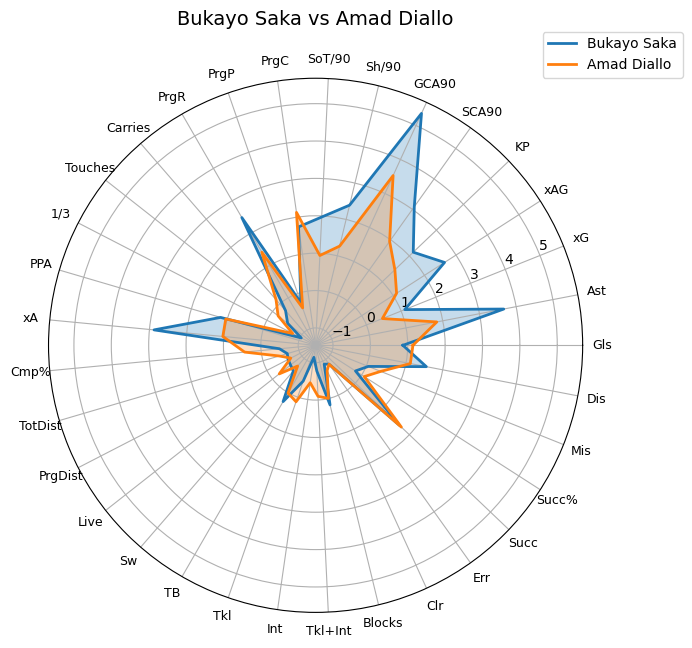

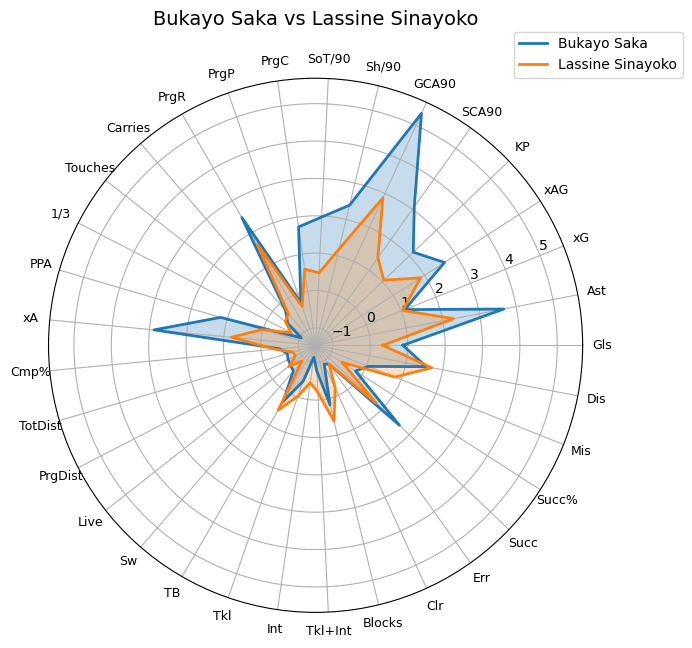

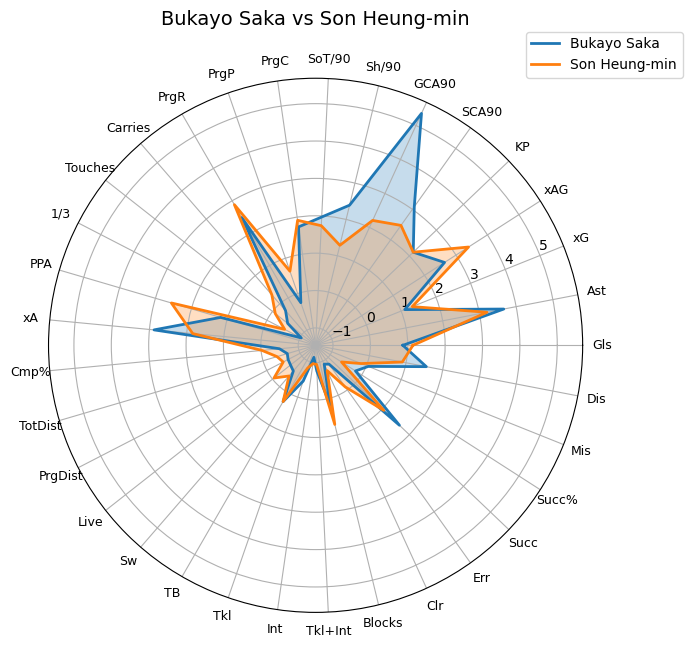

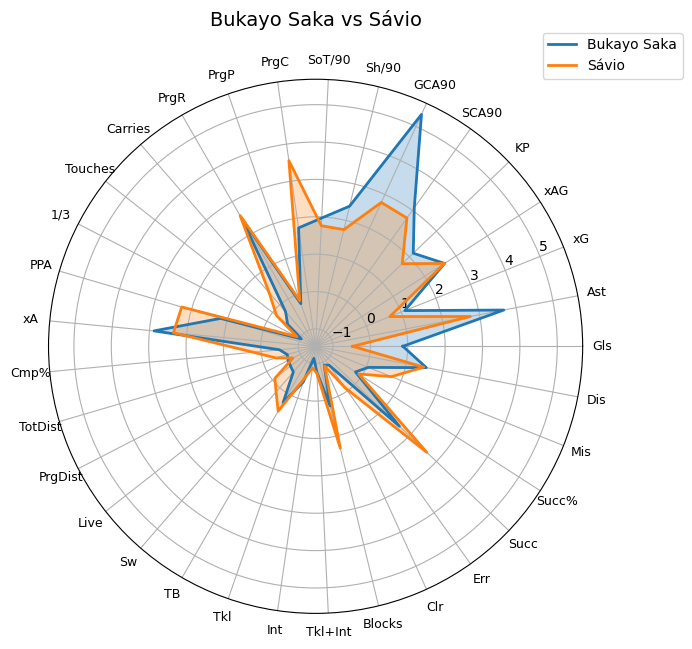

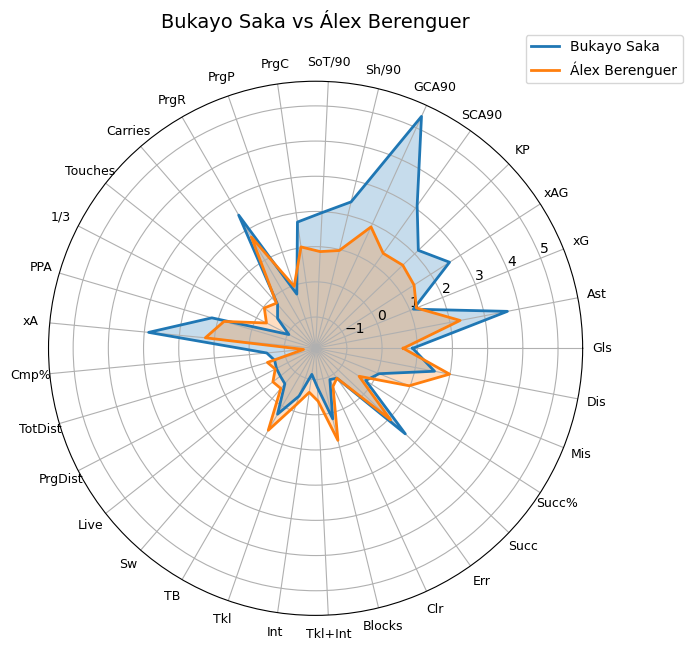

In [76]:
target, similars = get_top_similar_players(df_stats_scaled, feature_cols, "Saka", top_n=5)
plot_top5_radar_comparisons(target, similars, df_stats_scaled, feature_cols)


In [77]:
position_feature_map = {
    "FW": ['Gls', 'Ast', 'xG', 'xAG', 'KP', 'SCA90', 'GCA90', 'Sh/90', 'SoT/90', 'Succ', 'Succ%', 'Touches', 'xA'],
    
    "MF": ['Ast', 'xAG', 'xA', 'KP', 'SCA90', 'GCA90', 'PrgP', 'PrgC', 'PrgR', 'Carries', 'Touches', '1/3', 'PPA', 'Cmp%', 'TotDist', 'TB', 'Sw'],
    
    "DF": ['Tkl', 'Tkl+Int', 'Blocks', 'Clr', 'Err', 'Int', 'Cmp%', 'Touches', 'PrgP', 'PrgC', 'Carries'],
    
    "GK": ['Save%', 'GA90', 'CS%', 'PSxG+/-', 'Cmp%_stats_keeper_adv', 'AvgDist']
}


In [78]:
def simplify_position(pos):
    if isinstance(pos, str):
        if pos.startswith("GK"): return "GK"
        elif pos.startswith("D"): return "DF"
        elif pos.startswith("M"): return "MF"
        elif pos.startswith("F"): return "FW"
    return None


In [79]:
def get_top_similar_players_by_role(df_scaled, player_name, top_n=5):
    match = df_scaled[df_scaled['Player'].str.contains(player_name, case=False, na=False)]
    if match.empty:
        raise ValueError(f"No player found matching: {player_name}")

    target_idx = match.index[0]
    target_player = df_scaled.loc[target_idx, 'Player']
    pos = simplify_position(df_scaled.loc[target_idx, 'Pos'])

    if not pos or pos not in position_feature_map:
        raise ValueError(f"Unrecognized or unsupported position for player: {player_name} ({pos})")

    features = [f for f in position_feature_map[pos] if f in df_scaled.columns]

    # Scale if needed (here we assume already scaled)
    X = df_scaled[features].fillna(0)
    similarity_scores = cosine_similarity([X.loc[target_idx]], X)[0]

    df_scaled = df_scaled.copy()
    df_scaled['similarity'] = similarity_scores

    similar_players = df_scaled[df_scaled.index != target_idx]
    similar_players = similar_players.sort_values(by='similarity', ascending=False).head(top_n)

    return target_player, pos, features, similar_players[['Player', 'Squad', 'Pos', 'similarity']]


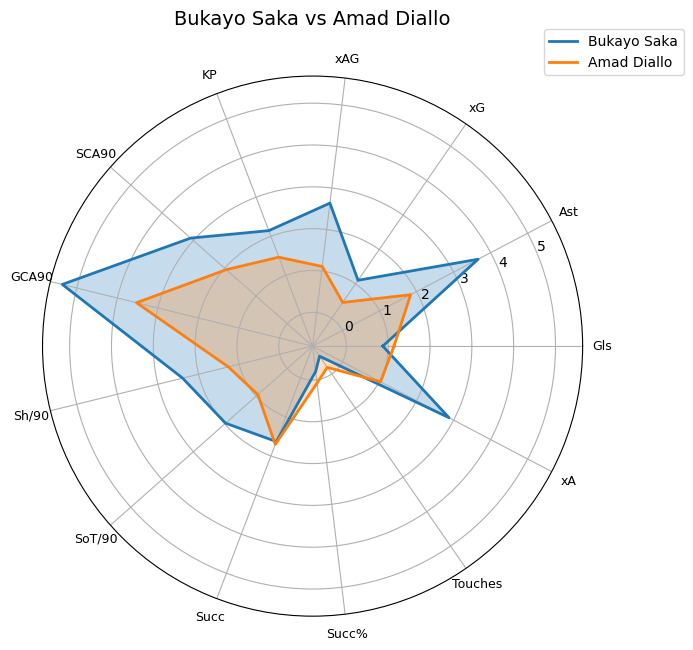

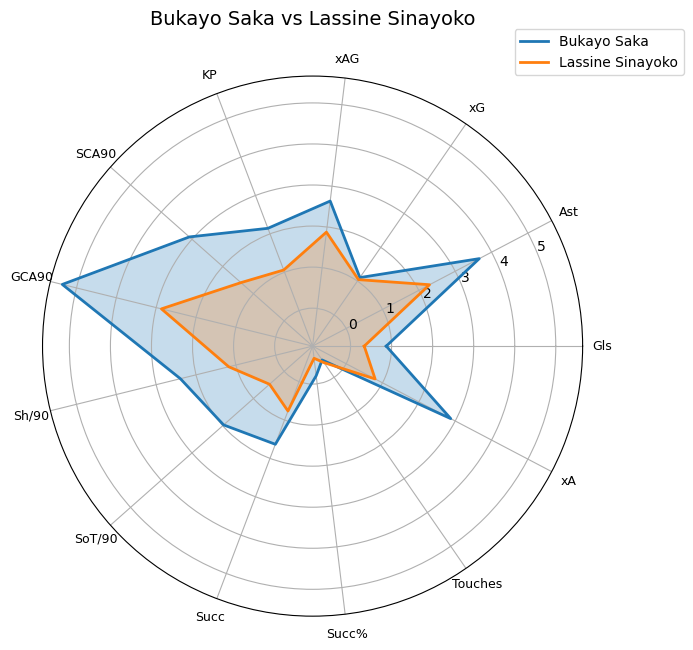

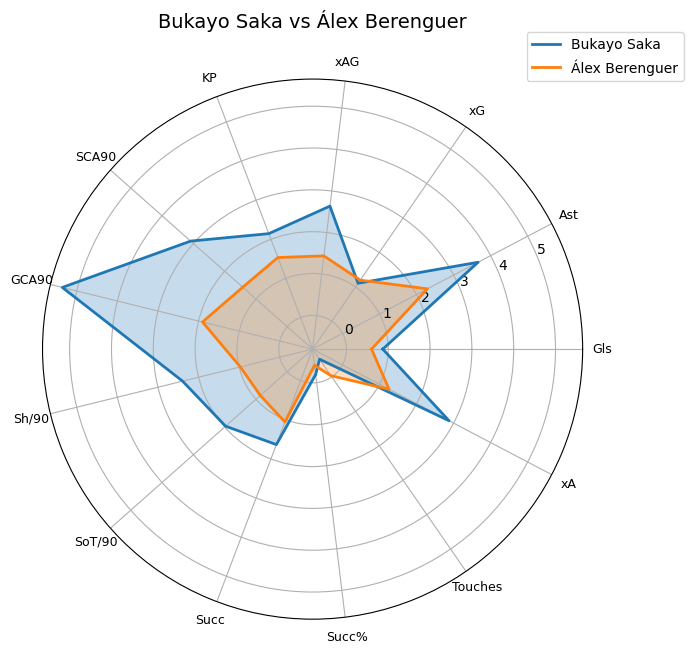

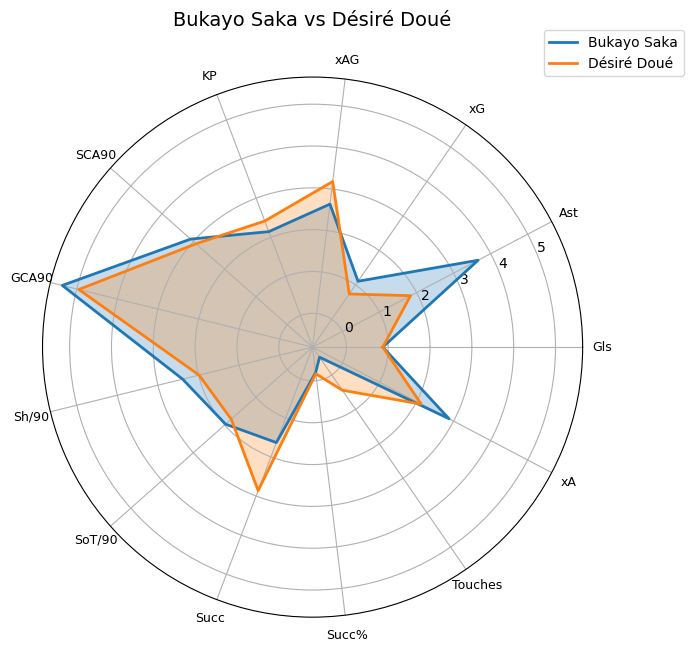

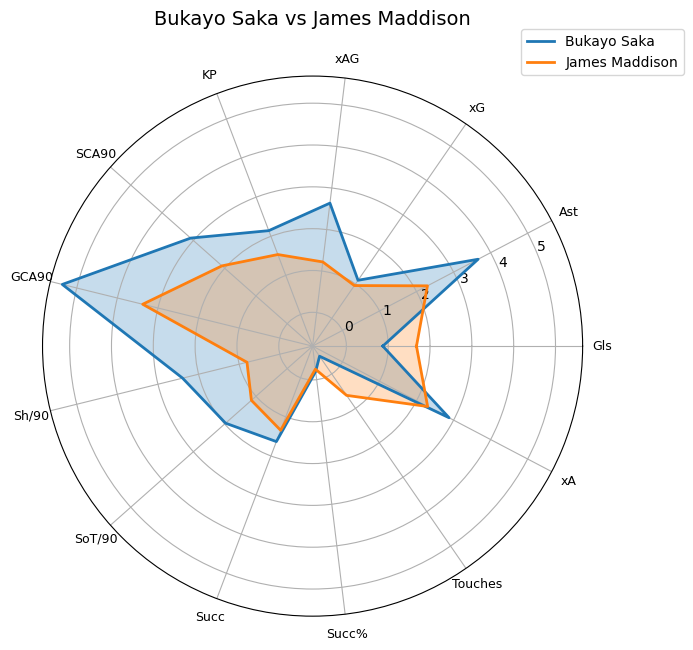

In [80]:
target, pos, features, similars = get_top_similar_players_by_role(df_stats_scaled, "Saka")
plot_top5_radar_comparisons(target, similars, df_stats_scaled, features)


In [81]:
scatter_axes_by_role = {
    "FW": ("xG", "xAG"),
    "MF": ("PrgP", "KP"),
    "DF": ("Tkl", "Int"),
    "GK": ("Save%", "PSxG+/-")
}


In [82]:
import matplotlib.pyplot as plt

def plot_role_scatter(df, target_player):
    # Get player info
    match = df[df['Player'].str.contains(target_player, case=False, na=False)]
    if match.empty:
        raise ValueError("Player not found.")
    
    idx = match.index[0]
    player = df.loc[idx, 'Player']
    pos = simplify_position(df.loc[idx, 'Pos'])
    
    if pos not in scatter_axes_by_role:
        raise ValueError(f"Unsupported position category for scatter plot: {pos}")
    
    x_col, y_col = scatter_axes_by_role[pos]
    if x_col not in df.columns or y_col not in df.columns:
        raise ValueError(f"Missing data columns: {x_col}, {y_col}")

    # Filter by position group
    df_role = df[df['Pos'].apply(simplify_position) == pos]

    plt.figure(figsize=(10, 7))
    plt.scatter(df_role[x_col], df_role[y_col], alpha=0.6, label="Peers")
    
    # Highlight target player
    px = df.loc[idx, x_col]
    py = df.loc[idx, y_col]
    plt.scatter(px, py, c='red', s=100, edgecolors='black', label=player)
    plt.text(px, py, player, fontsize=10, weight='bold', ha='right')

    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"{player} vs Positional Peers ({pos})")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


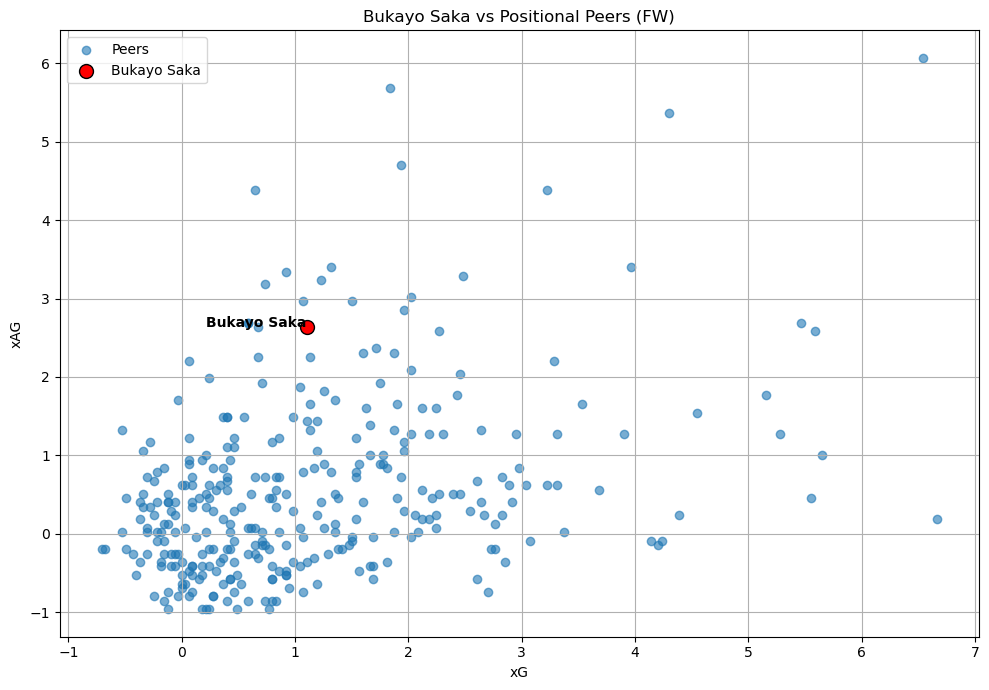

In [83]:
plot_role_scatter(df_stats_scaled, "Saka")


In [84]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_role_scatter_enhanced(df, target_player, size_col='Min', color_col='Comp'):
    match = df[df['Player'].str.contains(target_player, case=False, na=False)]
    if match.empty:
        raise ValueError("Player not found.")

    idx = match.index[0]
    player = df.loc[idx, 'Player']
    pos = simplify_position(df.loc[idx, 'Pos'])

    if pos not in scatter_axes_by_role:
        raise ValueError(f"Unsupported position category for scatter plot: {pos}")

    x_col, y_col = scatter_axes_by_role[pos]
    if x_col not in df.columns or y_col not in df.columns:
        raise ValueError(f"Missing columns for plotting: {x_col}, {y_col}")

    # Filter role group
    df_role = df[df['Pos'].apply(simplify_position) == pos].copy()

    # Fill missing sizes/colors if needed
    df_role[size_col] = df_role[size_col].fillna(0)
    df_role[color_col] = df_role[color_col].fillna("Unknown")

    # Normalize size for plotting
    sizes = df_role[size_col] / df_role[size_col].max() * 300

    # Encode color categories
    colors = pd.factorize(df_role[color_col])[0]

    # Plot
    plt.figure(figsize=(11, 8))
    scatter = plt.scatter(df_role[x_col], df_role[y_col], s=sizes, c=colors, cmap='tab10', alpha=0.65, edgecolors='w', linewidths=0.5)

    # Highlight player
    px, py = df.loc[idx, x_col], df.loc[idx, y_col]
    plt.scatter(px, py, c='red', s=400, edgecolors='black', label=player)
    plt.text(px, py, player, fontsize=10, weight='bold', ha='right', color='black')

    # Axis labels and title
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"{player} vs Peers ({pos}) — Colored by {color_col}, Sized by {size_col}")
    plt.grid(True)
    plt.tight_layout()

    # Optional legend placeholder
    plt.legend()
    plt.show()


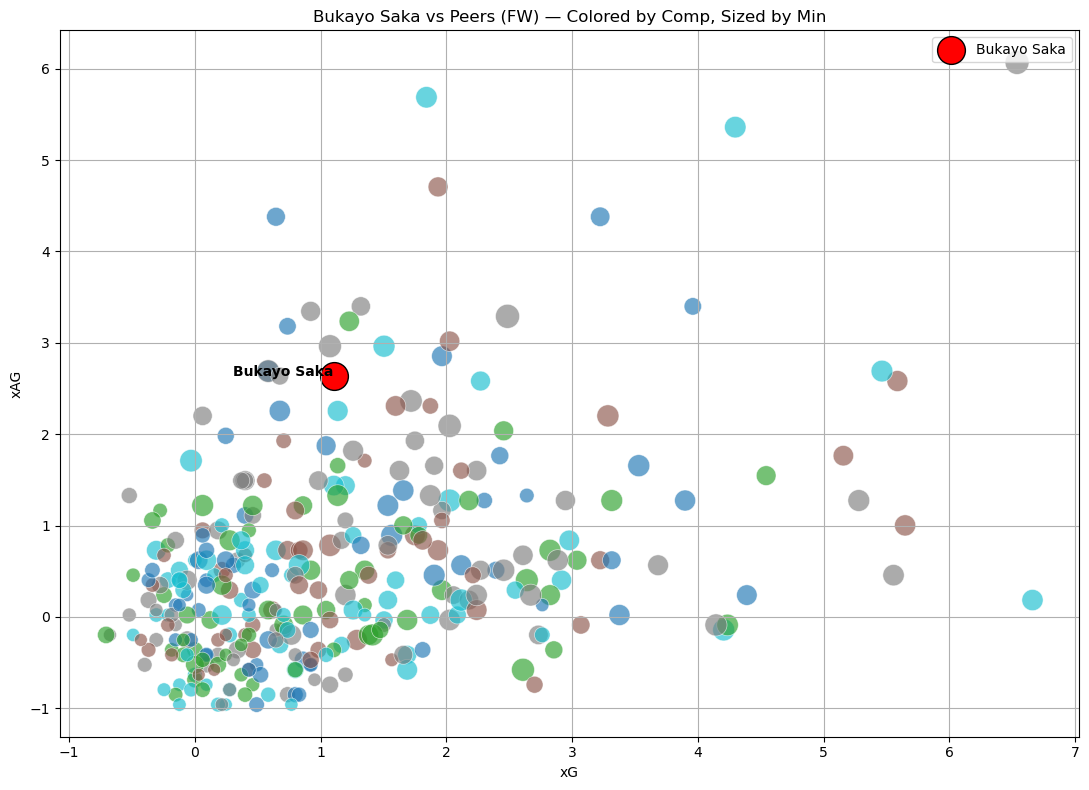

In [85]:
plot_role_scatter_enhanced(df_stats_scaled, "Saka", size_col='Min', color_col='Comp')


In [86]:
pip install plotly


Note: you may need to restart the kernel to use updated packages.


In [87]:
import plotly.express as px

def plot_interactive_scatter(df, target_player, size_col='Min', color_col='Comp'):
    match = df[df['Player'].str.contains(target_player, case=False, na=False)]
    if match.empty:
        raise ValueError("Player not found.")

    idx = match.index[0]
    player = df.loc[idx, 'Player']
    pos = simplify_position(df.loc[idx, 'Pos'])

    if pos not in scatter_axes_by_role:
        raise ValueError(f"Unsupported position category: {pos}")

    x_col, y_col = scatter_axes_by_role[pos]
    if x_col not in df.columns or y_col not in df.columns:
        raise ValueError(f"Missing columns: {x_col}, {y_col}")

    df_role = df[df['Pos'].apply(simplify_position) == pos].copy()
    df_role = df_role.fillna({size_col: 0, color_col: 'Unknown'})

    # Add highlight column
    df_role['Highlight'] = df_role['Player'].apply(lambda x: 'Target' if x == player else 'Peer')

    fig = px.scatter(
        df_role,
        x=x_col,
        y=y_col,
        size=size_col,
        color=color_col,
        hover_name="Player",
        hover_data=["Squad", "Pos", "Min", x_col, y_col],
        title=f"{player} vs Positional Peers ({pos})",
        opacity=0.8,
        size_max=15,
        template="plotly_white"
    )

    fig.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey')))
    fig.show()


In [88]:
plot_interactive_scatter(df_stats_scaled, "Saka", size_col='Min', color_col='Comp')


In [89]:
def player_prompt(df_scaled, player_name, top_n=5, size_col='Min', color_col='Comp'):
    try:
        # Step 1: Get similar players using role-aware comparison
        target, pos, features, similars = get_top_similar_players_by_role(df_scaled, player_name, top_n=top_n)

        # Step 2: Print result summary
        print(f"\nTop {top_n} stylistically similar players to {target} ({pos}):")
        print(similars)

        # Step 3: Plot radar comparisons
        print(f"\nGenerating radar charts comparing {target} to each similar player...")
        plot_top5_radar_comparisons(target, similars, df_scaled, features)

        # Step 4: Plot interactive scatter with hover
        print(f"\nDisplaying interactive scatter plot of {pos}s with {target} highlighted...")
        plot_interactive_scatter(df_scaled, target, size_col=size_col, color_col=color_col)

    except Exception as e:
        print(f"\n❌ Error: {e}")



Top 7 stylistically similar players to Joshua Kimmich (MF):
                      Player       Squad Pos  similarity
1351            Granit Xhaka  Leverkusen  MF    0.950455
373                  Éderson    Atalanta  MF    0.931618
986                    Pedri   Barcelona  MF    0.925906
36    Trent Alexander-Arnold   Liverpool  DF    0.923946
407           Enzo Fernández     Chelsea  MF    0.915831
109           Nicolò Barella       Inter  MF    0.915317
1094        Fabián Ruiz Peña   Paris S-G  MF    0.914983

Generating radar charts comparing Joshua Kimmich to each similar player...


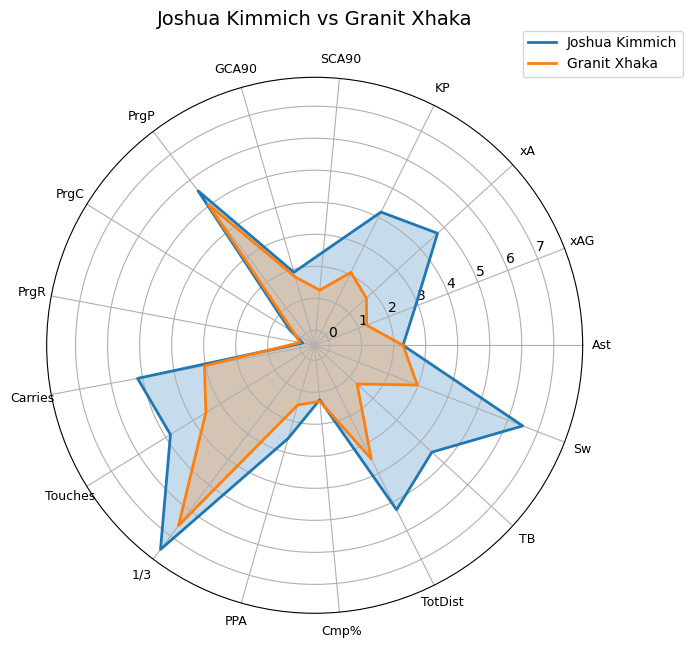

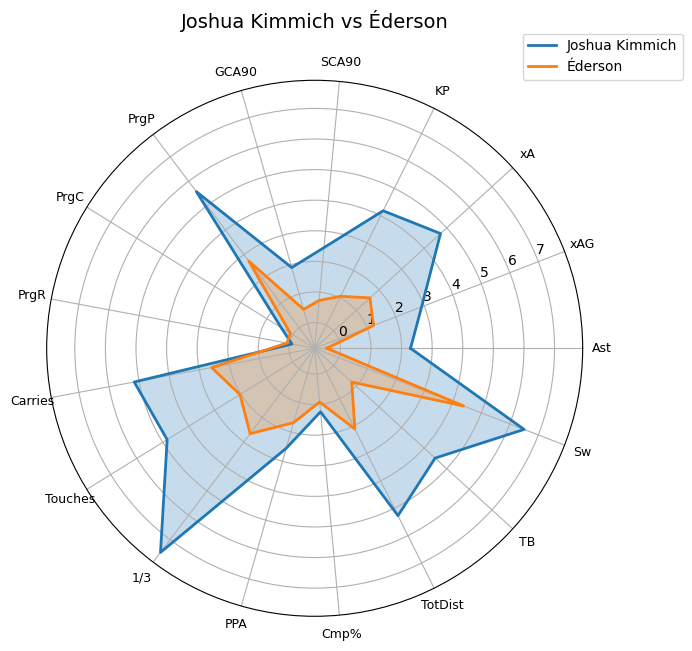

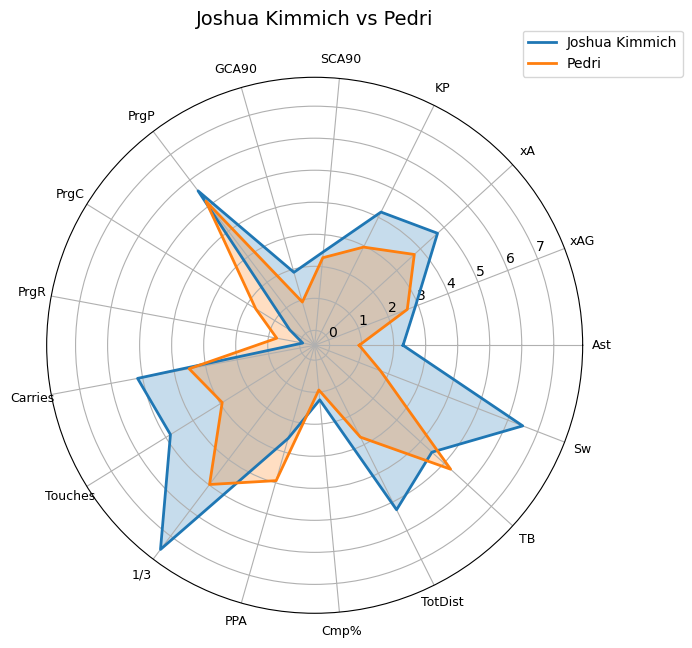

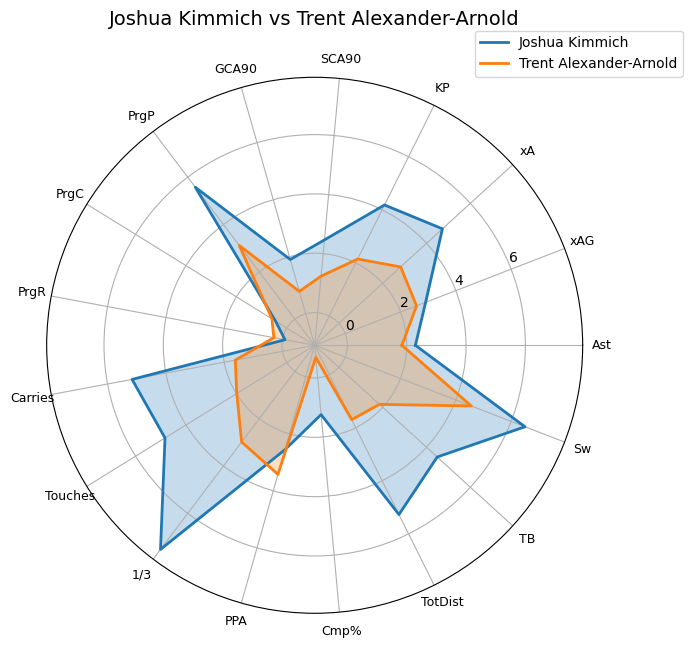

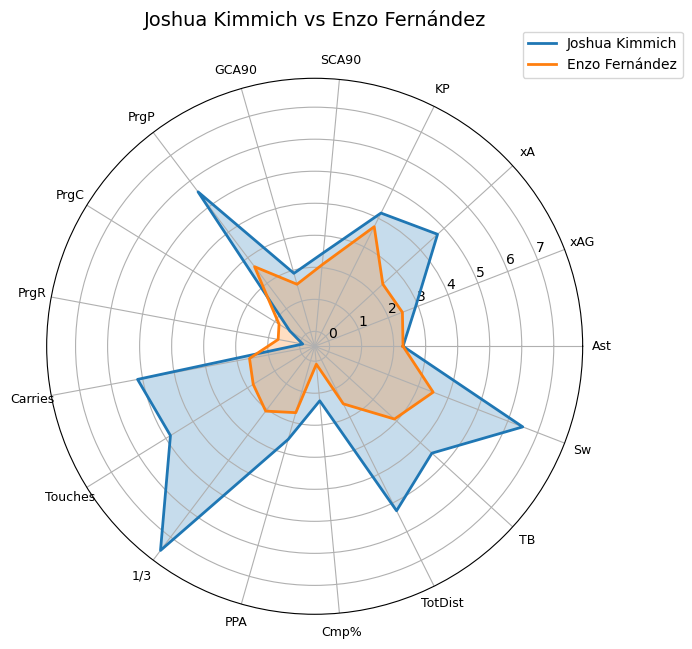

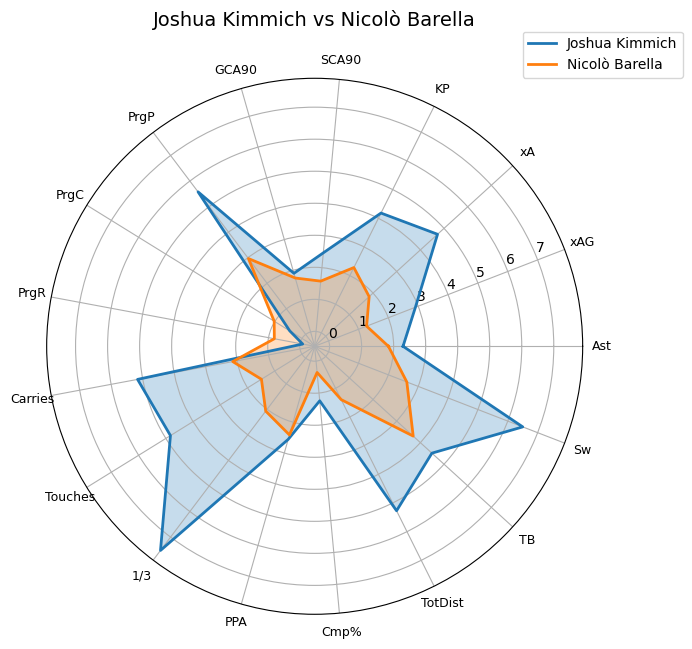

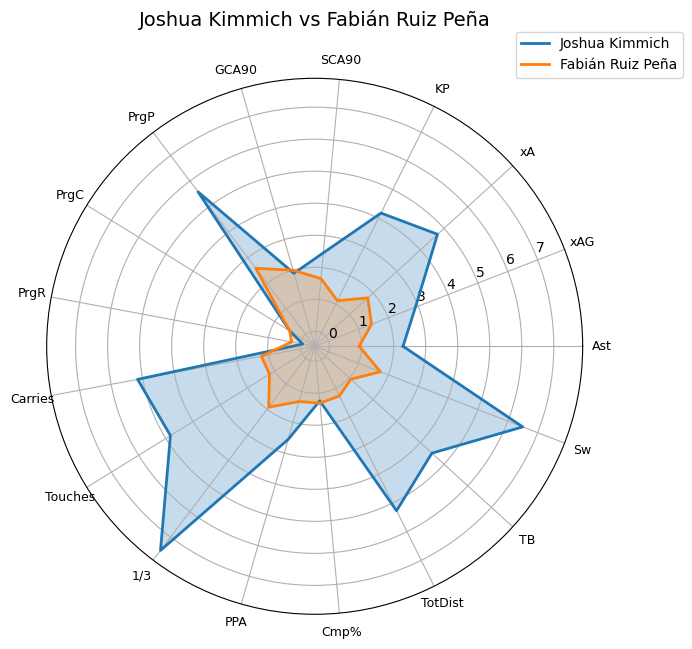


Displaying interactive scatter plot of MFs with Joshua Kimmich highlighted...


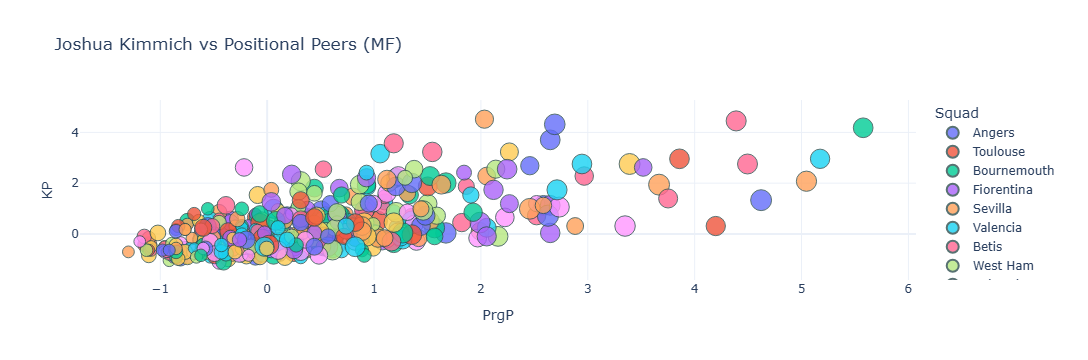

In [90]:
player_prompt(df_stats_scaled, "Kimmich", top_n=7, size_col="Min", color_col="Squad")


In [91]:
%%writefile player_comparison_app.py
# Paste your full Streamlit app code here
import streamlit as st
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import numpy as np

# -- Your existing functions here --
# simplify_position, get_top_similar_players_by_role, plot_top5_radar_comparisons, etc.

# Load preprocessed DataFrame (assume it's already scaled and available)
@st.cache_data
def load_data():
    return pd.read_csv("players_data-2024_2025.csv")

df = load_data()

# Sidebar inputs
st.sidebar.title("Player Comparison App")
player_name = st.sidebar.text_input("Enter a player name")
chart_type = st.sidebar.radio("Choose chart type", ["Radar", "Scatter"])
top_n = st.sidebar.slider("# of similar players", min_value=3, max_value=10, value=5)

if player_name:
    try:
        # Get similar players and appropriate features
        target, pos, features, similars = get_top_similar_players_by_role(df, player_name, top_n=top_n)

        st.success(f"Top {top_n} stylistic matches for {target} ({pos})")
        st.dataframe(similars)

        if chart_type.lower() == "radar":
            st.subheader("Radar Charts")
            for _, row in similars.iterrows():
                fig = build_plotly_radar(target, row['Player'], df, features)  # build_plotly_radar must use Plotly
                st.plotly_chart(fig)

        elif chart_type.lower() == "scatter":
            st.subheader("Scatter Plot")
            fig = build_interactive_scatter(df, target, size_col='Min', color_col='Comp')
            st.plotly_chart(fig)

    except Exception as e:
        st.error(f"Error: {e}")
else:
    st.info("Enter a player name to get started.")


Overwriting player_comparison_app.py


In [92]:
%%writefile test_script.py
print("This should be instant.")


Overwriting test_script.py


In [93]:
%%writefile test_script.py
print("This should be instant.")


Overwriting test_script.py


In [100]:
# in a cell or inside your app under a “debug” flag
player, pos, feats, top5 = get_top_similar_players_by_role(df, "Bukayo Saka", 5)
print(pos, feats)



NameError: name 'df' is not defined